# Applying the Apeep calculations to an `xarray` dataset

Throughout this notebook, you will see the `@jit(nopython=True)` lines which are wrappers which translate Python code to optimized code at run time - this helps improve the performance

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from scipy import integrate
from numba import jit

### Calculating an energy spectrum for a specific l-shell and AP calculation
A routine (vdk2016) to return an energy spectrum for a specific l-shell and Ap
Calcs based on: 

***van de Kamp, M., Seppälä, A., Clilverd, M. A., Rodger, C. J., Verronen, P. T., and Whittaker, I. C. (2016), A model providing long‐term datasets of energetic electron precipitation during geomagnetic storms, J. Geophys. Res. Atmos., 121, 12,520– 12,540, [doi:10.1002/2015JD024212](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2015JD024212).***

In [2]:
@jit(nopython=True)
def vdk2016(e, l, Ap):

    lpp = -0.7430*np.log(Ap) + 6.5257
    Spp = l - lpp

    # vdK2016 eqn.(8)

    A = 8.2091*Ap**0.16255
    b = 1.3754*Ap**0.33042
    c = 0.13334*Ap**0.42616
    s = 2.2833*Ap**-0.22990
    d = 2.7563e-4*Ap**2.6116

    # integral flux >30 keV (F30) electrons / (cm2 sr s)
    F30 = np.exp(A) / (np.exp(-b*(Spp-s)) + np.exp(c*(Spp-s)) + d)

    # vdK2016 eqn.(9)

    E = 3.3777*Ap**-1.7038 + 0.15
    bk = 3.7632*Ap**-0.16034
    sk = 12.184*Ap**-0.30111

    k = -1.0 / (E*np.exp(-bk*Spp) + 0.30450*np.cosh(0.20098*(Spp-sk))) - 1
    
    # solve eqn 3 for C
    # C is an offset, and k is the spectral gradient
    x=k+1
    c = F30*x/(1e3**x-30.**x)
    
    # calcualte the spectral density of the flux S(E) = CE^k
    # in electrons / (cm2 sr s keV)
    flux_spectral_density = e**k*c
    
    return flux_spectral_density

### Calculate how energy from top of atmosphere is deposited in rest of atmosphere

The function takes the energy spectrum at the top of the atmosphere and 
calculates how that energy is deposited in the atmosphere using the parameterization
described in [Fang et al., (2010)](https://opensky.ucar.edu/islandora/object/articles:10653)

***Fang, X., C. E. Randall, D. Lummerzheim, W. Wang, G. Lu, S. C. Solomon, 
and R. A. Frahm (2010), Parameterization of monoenergetic electron impact
ionization, Geophys. Res. Lett., 37, L22106, [doi:10.1029/2010GL045406.](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2010GL045406)***

Application of the new parameterization requires the following steps:

1. Calculate the Ci coefficients using equation (5) and Table 1.
2. Calculate the y values throughout the atmosphere using equation (1).
3. Calculate the normalized energy dissipation f values using equation (4).
4. Obtain the altitude profile of qtot by substituting the f values into equation (3).

In [3]:
@jit(nopython=True)
def fang(y, Emono):
# Input: 
# y - normalized atmospheric column mass as a function of vertical location (z)
# Emono - is incident electron energy (keV)
# Output:
# f - quanity calculated by eqn. (4)

    # Table 1.
    p1 = np.array([(1.24616E+0,  1.45903E+0, -2.42269E-1,  5.95459E-2), 
                   (2.23976E+0, -4.22918E-7,  1.36458E-2,  2.53332E-3),
                   (1.41754E+0,  1.44597E-1,  1.70433E-2,  6.39717E-4),
                   (2.48775E-1, -1.50890E-1,  6.30894E-9,  1.23707E-3),
                   (-4.65119E-1, -1.05081E-1, -8.95701E-2,  1.22450E-2),
                   (3.86019E-1,  1.75430E-3, -7.42960E-4,  4.60881E-4),
                   (-6.45454E-1,  8.49555E-4, -4.28581E-2, -2.99302E-3),
                   (9.48930E-1,  1.97385E-1, -2.50660E-3, -2.06938E-3)])

    # terms in eq. (5)
    lne = np.log(Emono)
    lne2 = lne*lne
    lne3 = lne*lne2

    # step 2. calculate the C array in (5)
    c = np.empty((8))
    for i in range(8):
        c[i] = np.exp(p1[i,0] + p1[i,1]*lne + p1[i,2]*lne2 + p1[i,3]*lne3)
        
    # eq. (4) - Normalized energy deposition
    f = c[0]*y**c[1]*np.exp(-c[2]*y**c[3]) + c[4]*y**c[5]*np.exp(-c[6]*y**c[7])
    
    return f

In [4]:
@jit(nopython=True)
def iprmono(e, flux, rho, H):
    # assign constants
    epsilon = 0.035 # keV 

    ipr = np.empty((e.size,rho.size))

    for i,energy in enumerate(e): # loop over energy index

        # step 1. (eq. 1) 
        y = (2/energy)*(rho*H/6.0e-6)**0.7
        f = np.empty(y.size)

        for j,yy in enumerate(y):
            f[j] = fang(yy, energy)

        # calculate ipr (qtot) using eq. (3) for a specified flux at ea. energy
        Qmono = flux[i]*energy # (keV cm−2 s−1)
        ipr[i,:] = f*Qmono/(epsilon*H)

    return ipr

### Generate an energy grid

In [5]:
# Generate a grid of energies for the flux spectrum
# The energy range of the spectrum was set at 30–1000 keV, 
# with nbins of logarithmically spaced grid points.

@jit(nopython=True)
def gen_energy_grid(nbins):

    e1 = np.log10(30.)
    e2 = np.log10(1000.)
    e = 10**(e1 + (e2-e1)*np.arange(nbins)/(nbins-1))
    
    return e

In [6]:
nbins = 128 # sets resolution of the grid
e = gen_energy_grid(nbins)

### Read in standard atmosphere data
Read in the Atmospheric density (rho) and temperature
return rho and the scale height (H) as a function of altitude 

In [7]:
def read_atm():
    
    # assign constants
    kboltz = 1.380649e-23 # (J/K)
    amu = 1.6605e-27 # (kg)    
    grav = 9.8 # m/s2

    # read msis atmosphere
    x = pd.read_table('../data/msis2.0_atm_out.txt', header=0, sep='\s+')

    t = x['T']
    rho = x['rho']
    alt = x['alt']
    
    # calculate H, the scale height (cm)
    H = kboltz*t/(28.6*amu*grav)*1e2 

    return H, rho, alt

In [8]:
H, rho, alt = read_atm()

## Put it all together - create a function that processes a single ap, and single glat value
Here, we use numba to improve the speed, looping through a list of glats and aps

In [9]:
@jit(nopython=True)
def calculate_ipr(glats, aps, alt=alt.values, rho=rho.values, H=H.values, e=e):
    ipr_vals = np.empty(shape=(len(aps),len(glats), len(e), len(alt)))
    for i in range(len(aps)):
        for j in range(len(glats)):
            l = 1.01 / np.cos(glats[j]*np.pi/180.)**2
            # calculate the top of the atmosphere energetic electron energy spectrum
            flux = vdk2016(e, l, aps[i])

            # calculate the IPR as a function f height and energy
            ipr = iprmono(e, flux, rho, H)
            
            # Add the results to the ipr array
            ipr_vals[i, j, :, :] = ipr
            
    return ipr_vals

We need to now create a function to interface with `Xarray`, and apply the `integrate.simpson` function since that is not easily read in by numba

In [10]:
def calculate_iprm(ds, alt=alt.values, rho=rho.values, H=H.values, e=e):
    """
    Calculates iprm from a dataset
    """
    
    # Read in the glats and aps
    glats = ds.glat.values
    aps = ds.ap.values
    times = ds.time.values
    
    ipr = calculate_ipr(glats, aps, alt=alt, rho=rho, H=H, e=e)
    
    # calculate ipr total by integrating across the energy spectrum
    ipr_tot = integrate.simps(ipr, e, axis=2)
    
    # calculate iprm
    iprm = ipr_tot/rho
    
    # Calculate pressure levels
    plevs = 1013.*np.exp(-alt/6.8)
    
    # Build a dataset for the output
    out_ds = xr.Dataset(data_vars=dict(iprm=(['time', 'glat', 'pressure'], iprm),
                                       ap = (['time'], aps),
                                       glat = glats,
                                       pressure = plevs,
                                       time=times))
    out_ds = out_ds.transpose("time", "pressure", "glat")
    
    return out_ds.sortby('pressure')

## Try this on the dataset

### Read in the dataset

In [11]:
ds = xr.open_dataset('../../../../solar_weather/solarforcing-REFD1-day_input4MIPs_solar_CCMI-2022_SOLARIS-HEPPA-3-2_gn_19500101-20191231.nc')

### Subset a time slice of the data, and apply the function

In [12]:
%%time
ds_sub = ds.isel(time=range(10))
ds_calc = calculate_iprm(ds_sub)

CPU times: user 4.61 s, sys: 50.8 ms, total: 4.66 s
Wall time: 4.65 s


### Plot the results!

#### Derived quantity using the method described above

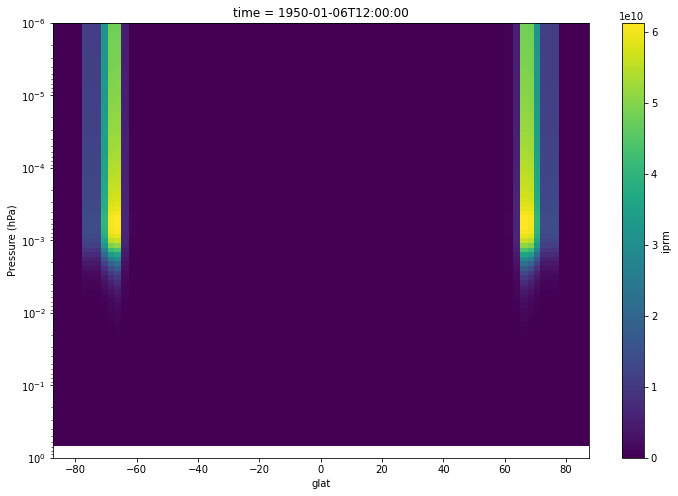

In [13]:
plt.figure(figsize=(12,8))

ax = plt.gca()
ds_calc.iprm.isel(time=5).plot(ax=ax)
ax.set_ylim([1,1e-6])
ax.set_yscale('log')
ax.set_ylabel('Pressure (hPa)');

#### Original dataset

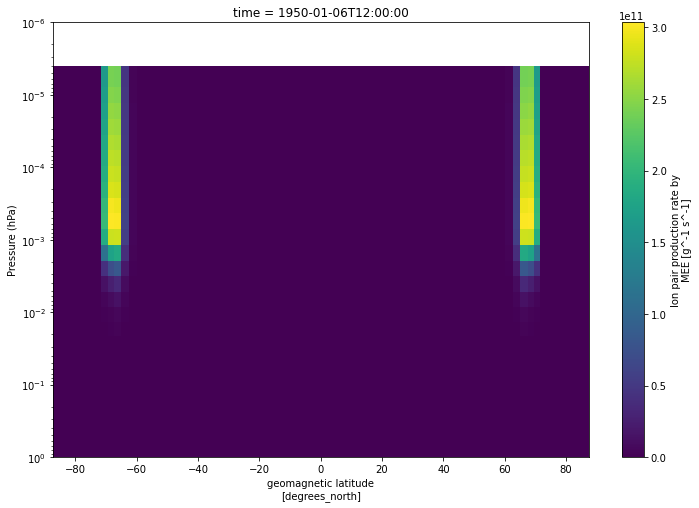

In [14]:
plt.figure(figsize=(12,8))

ax = plt.gca()

ds.iprm.isel(time=5).plot(ax=ax)


ax.set_ylim([1,1e-6])
ax.set_yscale('log')
ax.set_ylabel('Pressure (hPa)');